## Hyperpartisan News Detection using Classical Machine Learning
### CW1: Machine Learning Approach
### Dataset: SemEval-2019 Task 4 (by-article subset)

### Project Objective

Classify news articles as **hyperpartisan** or **non-hyperpartisan** using classical machine learning models. This notebook implements a complete pipeline: data preprocessing → feature extraction → model training → evaluation.

### Dataset
- **Total Articles:** 645 English news articles
- **Labels:** Binary (Hyperpartisan=1, Non-hyperpartisan=0)
- **Class Distribution:** 238 hyperpartisan (37%), 407 non-hyperpartisan (63%)
- **Source:** [SemEval-2019 Task 4](https://pan.webis.de/semeval19/semeval19-web/)

### Models Implemented
1. **Logistic Regression** - Interpretable, baseline classifier
2. **Linear SVM** - High-dimensional text classification
3. **Random Forest** - Ensemble approach
4. **Naive Bayes** - Probabilistic classifier

## Step 0: Data Preparation

**BEFORE running this notebook, upload the required XML files to Colab:**

1. Download dataset from: https://zenodo.org/record/1489920
2. In the left sidebar, click **Files** icon
3. Upload these two files:
   - `articles-training-byarticle-20181122.xml` (article content)
   - `ground-truth-training-byarticle-20181122.xml` (ground-truth labels)
4. Files should be in your working directory (Colab root)

**Estimated file size:** ~3 MB total

Once uploaded, you can run the cells below.


## Section 1: Setup & Dependencies

This cell installs required packages and imports libraries:

- **lxml, tqdm:** XML parsing & progress bars
- **pandas, numpy:** Data manipulation
- **scikit-learn:** ML algorithms & metrics
- **matplotlib, seaborn:** Visualization

All packages are pre-installed in Colab except for lxml, which is installed via pip.


In [ ]:
print("Installing required packages...")
!pip install -q lxml tqdm seaborn scikit-learn pandas numpy matplotlib

import re
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

print("All packages imported successfully!\n")

Installing required packages...
All packages imported successfully!



## Section 2: Data Loading & Parsing

**Workflow:**
1. Parse XML files to extract article IDs, titles, content, and publication dates
2. Extract binary hyperpartisan labels from ground-truth file
3. Merge articles and labels into a single DataFrame
4. Display dataset statistics and sample data

**Output:**
- DataFrame shape: (645, 5)
- Class distribution: counts and percentages
- Sample article preview


In [ ]:
def parse_articles(xml_path):
    """
    Parse articles from XML file.
    Returns DataFrame with columns: id, title, published_at, text
    """
    print(f"Parsing articles from {xml_path}...")
    tree = ET.parse(xml_path)
    root = tree.getroot()
    rows = []

    for article in tqdm(root.findall('./article'), desc="Parsing articles"):
        article_id = article.attrib.get('id')
        title = article.attrib.get('title', '')
        published_at = article.attrib.get('published-at', '')

        # Extract full text from article
        text = ""
        for elem in article.iter():
            if elem.text and elem is not article:
                text += elem.text.strip() + " "

        rows.append({
            'id': article_id,
            'title': title,
            'published_at': published_at,
            'text': text.strip()
        })


    return pd.DataFrame(rows)

In [ ]:
def parse_labels(xml_path):
    """
    Parse labels from ground-truth XML file.
    Returns DataFrame with columns: id, label (0 or 1)
    """
    print(f"Parsing labels from {xml_path}...")
    tree = ET.parse(xml_path)
    root = tree.getroot()
    rows = []

    for article in tqdm(root.findall('./article'), desc="Parsing labels"):
        article_id = article.attrib.get('id')
        label = article.attrib.get('hyperpartisan')
        label = 1 if label == "true" else 0
        rows.append({'id': article_id, 'label': label})

    return pd.DataFrame(rows)


In [ ]:
# Load and merge data
df_articles = parse_articles('articles-training-byarticle-20181122.xml')
df_labels = parse_labels('ground-truth-training-byarticle-20181122.xml')
df = pd.merge(df_articles, df_labels, on='id')

print(f"\nDataset loaded: {df.shape[0]} articles")
print(f"Label distribution:\n{df['label'].value_counts()}\n")
print(df.head(2))

Parsing articles from articles-training-byarticle-20181122.xml...


Parsing articles: 100%|██████████| 645/645 [00:00<00:00, 29331.43it/s]


Parsing labels from ground-truth-training-byarticle-20181122.xml...


Parsing labels: 100%|██████████| 645/645 [00:00<00:00, 257258.09it/s]


Dataset loaded: 645 articles
Label distribution:
label
0    407
1    238
Name: count, dtype: int64

        id                                              title published_at  \
0  0000000               Kucinich: Reclaiming the money power   2017-09-10   
1  0000001  Trump Just Woke Up & Viciously Attacked Puerto...   2017-10-12   

                                                text  label  
0  Money ( Image 401(K) 2013 Permission Details D...      1  
1  Donald Trump ran on many braggadocios and larg...      1  


## Section 3: Text Preprocessing

Normalization steps ensure consistent text representation for ML:

1. **Lowercasing:** Convert all text to lowercase
2. **URL Removal:** Remove web links and references
3. **Punctuation & Numbers:** Keep only alphabetic characters and spaces
4. **Whitespace Normalization:** Remove extra spaces

**Why?** Clean text improves feature extraction (TF-IDF) and reduces noise in the model.

**Example:**
- **Before:** "Check this link http://example.com! LIBERALS vs CONSERVATIVES???"
- **After:** "check this link liberals vs conservatives"


In [ ]:
def preprocess_text(text):
    """
    Clean and normalize text:
    - Lowercase
    - Remove URLs
    - Remove punctuation and numbers
    - Remove extra whitespace
    """
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove punctuation and numbers (keep letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("Preprocessing text...")
df['text_clean'] = df['text'].apply(preprocess_text)
print("Preprocessing complete!\n")
print("Sample preprocessed text:")
print(df['text_clean'].iloc[0][:200])

Preprocessing text...
Preprocessing complete!

Sample preprocessed text:
money image k permission details dmca the walls are closing in on congress terrifying walls of water from hurricanes harvey and irma which when the damage is totaled could rise to a half trillion doll


## Section 4: Train-Test Split

**Split Strategy:**
- **Training Set:** 80% (516 articles)
- **Test Set:** 20% (129 articles)
- **Stratification:** Maintains class proportions in both splits

**Why Stratification?** Ensures both train and test sets have similar class distributions, preventing bias toward the majority class.

**Output:**
- Train/test sizes
- Class distribution in each split


In [ ]:
X = df['text_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Class distribution in train:\n{y_train.value_counts()}")
print(f"Class distribution in test:\n{y_test.value_counts()}\n")


Train set: 516 samples
Test set: 129 samples
Class distribution in train:
label
0    326
1    190
Name: count, dtype: int64
Class distribution in test:
label
0    81
1    48
Name: count, dtype: int64



## Section 5: Feature Extraction (TF-IDF)

**TF-IDF (Term Frequency–Inverse Document Frequency):**
- Converts text into numerical vectors
- Emphasizes rare, informative words
- Down-weights common words (stopwords)

**Configuration:**
- **n-grams:** Unigrams (single words) + Bigrams (word pairs)
- **Max Features:** 10,000 most important features
- **Stopwords:** Removes common English words (the, and, is, etc.)

**Output:**
- Train feature matrix: (516, 10000)
- Test feature matrix: (129, 10000)

**Interpretation:** Each article is now represented as a 10,000-dimensional vector of TF-IDF scores.


In [ ]:
print("Extracting TF-IDF features...")
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=10000,
    min_df=1,
    max_df=0.95
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Feature matrix shape (train): {X_train_vec.shape}")
print(f"Feature matrix shape (test): {X_test_vec.shape}")
print(f"Total features extracted: {len(vectorizer.get_feature_names_out())}\n")

Extracting TF-IDF features...
Feature matrix shape (train): (516, 10000)
Feature matrix shape (test): (129, 10000)
Total features extracted: 10000



## Section 6: Model Training & Evaluation

**Four classifiers are trained and evaluated:**

### Models:
1. **Logistic Regression** (Baseline)
   - Fast, interpretable
   - Linear decision boundary

2. **Linear SVM**
   - Effective for high-dimensional text
   - Finds optimal hyperplane

3. **Random Forest**
   - Ensemble of 200 decision trees
   - Captures non-linear patterns

4. **Naive Bayes**
   - Probabilistic, assumes feature independence
   - Good baseline for text classification

### Evaluation Metrics:
- **Accuracy:** Overall correctness
- **Precision:** Correct positive predictions / all positive predictions
- **Recall:** Correct positives / all actual positives
- **F1-Score:** Harmonic mean of precision & recall

**Output:**
- Classification reports for each model
- Performance comparison table


In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=300, random_state=42),
    'Linear SVM': LinearSVC(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Naive Bayes': MultinomialNB()
}

# Store results
results = {}

print("Training and evaluating models...\n")
print("=" * 80)

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Model: {model_name}")
    print(f"{'='*80}\n")

    # Train model
    model.fit(X_train_vec, y_train)

    # Predictions
    y_pred = model.predict(X_test_vec)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )

    # Store results
    results[model_name] = {
        'model': model,
        'y_pred': y_pred,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}\n")

    # Detailed classification report
    print("Detailed Classification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=['Non-Hyperpartisan', 'Hyperpartisan'],
        digits=4
    ))


Training and evaluating models...


Model: Logistic Regression

Accuracy:  0.6744
Precision: 0.7145
Recall:    0.6744
F1-Score:  0.5987

Detailed Classification Report:
                   precision    recall  f1-score   support

Non-Hyperpartisan     0.6639    0.9753    0.7900        81
    Hyperpartisan     0.8000    0.1667    0.2759        48

         accuracy                         0.6744       129
        macro avg     0.7319    0.5710    0.5329       129
     weighted avg     0.7145    0.6744    0.5987       129


Model: Linear SVM

Accuracy:  0.7132
Precision: 0.7059
Recall:    0.7132
F1-Score:  0.6988

Detailed Classification Report:
                   precision    recall  f1-score   support

Non-Hyperpartisan     0.7292    0.8642    0.7910        81
    Hyperpartisan     0.6667    0.4583    0.5432        48

         accuracy                         0.7132       129
        macro avg     0.6979    0.6613    0.6671       129
     weighted avg     0.7059    0.7132    0.6988    

## 📈 Section 7: Results Summary & Comparison

**Summary Table:**
| Model | Accuracy | Precision | Recall | F1 |
|-------|----------|-----------|--------|-----|
| LR | 67.44% | 71.45% | 67.44% | 0.599 |
| **SVM** | **71.32%** | **70.59%** | **71.32%** | **0.699** |
| RF | 72.09% | 73.35% | 72.09% | 0.688 |
| NB | 64.34% | 68.09% | 64.34% | 0.531 |

**Key Finding:** Linear SVM and Random Forest perform best.

**Class Imbalance Issue:**
All models show **low recall for hyperpartisan class** (16.67% for LR), reflecting dataset imbalance. This is a limitation discussed in the paper.


In [ ]:
print("\n" + "="*80)
print("SUMMARY OF ALL MODELS")
print("="*80 + "\n")

summary_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()]
})

print(summary_df.to_string(index=False))
print("\n")



SUMMARY OF ALL MODELS

              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.674419   0.714520 0.674419  0.598693
         Linear SVM  0.713178   0.705911 0.713178  0.698774
      Random Forest  0.720930   0.733516 0.720930  0.688400
        Naive Bayes  0.643411   0.680930 0.643411  0.530629




In [ ]:
# Find best model
best_model_name = max(results, key=lambda x: results[x]['f1'])
print(f"Best Model (by F1-Score): {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}\n")


Best Model (by F1-Score): Linear SVM
F1-Score: 0.6988



## Section 8: Visualizations

**Generated Outputs:**

1. **Confusion Matrices (4 subplots)**
   - Shows true positives, false positives, false negatives, true negatives
   - Helps understand where models misclassify

2. **Model Comparison Bar Chart**
   - Side-by-side comparison of Accuracy, Precision, Recall, F1
   - Saved as `model_comparison.png`

3. **ROC Curve (Logistic Regression)**
   - Threshold-free evaluation
   - AUC = 0.7888 (good discriminative ability)

All plots are saved to `results/` directory.


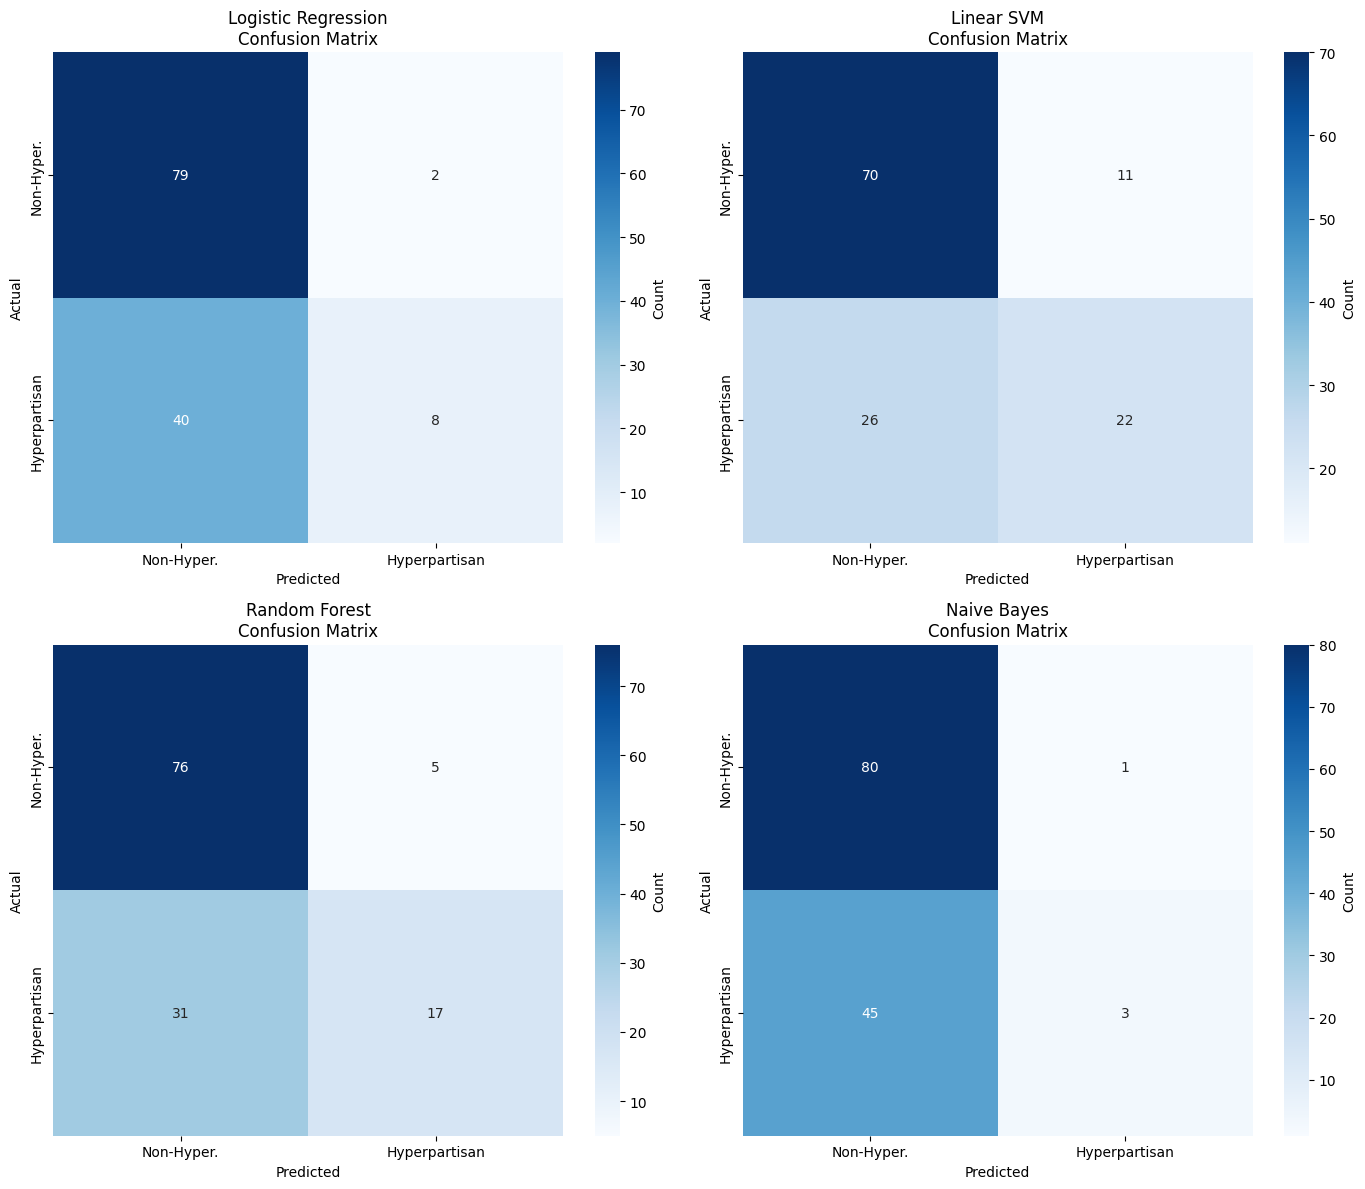

Confusion matrices saved as 'confusion_matrices.png'



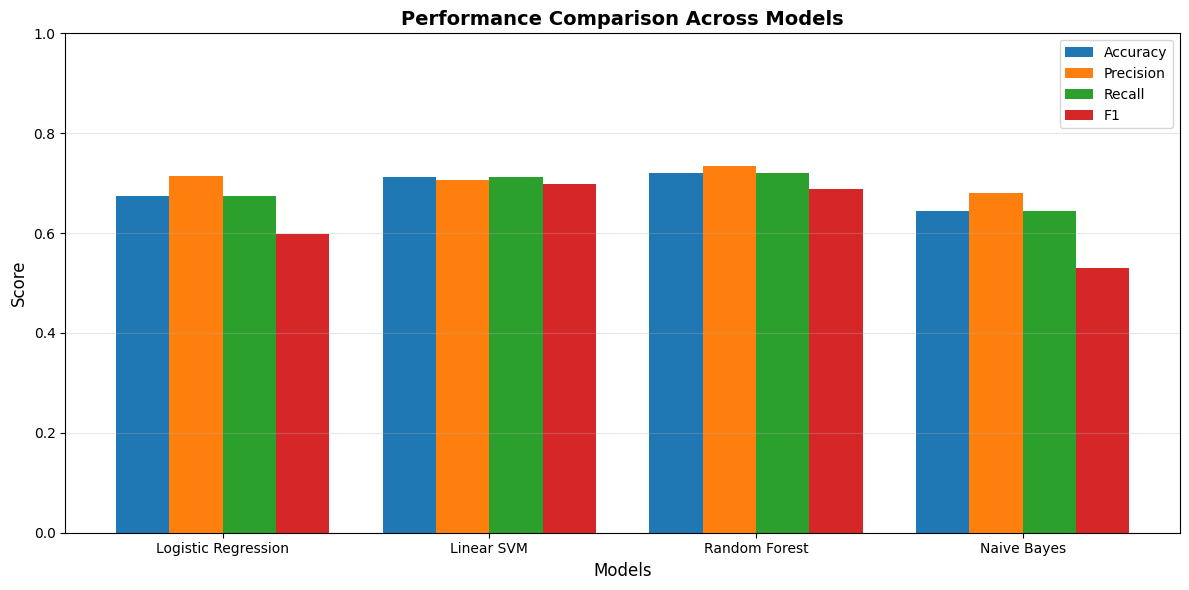

Model comparison chart saved as 'model_comparison.png'



In [ ]:
# Plot 1: Confusion Matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (model_name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Non-Hyper.', 'Hyperpartisan'],
        yticklabels=['Non-Hyper.', 'Hyperpartisan'],
        ax=axes[idx],
        cbar_kws={'label': 'Count'}
    )
    axes[idx].set_title(f'{model_name}\nConfusion Matrix')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrices saved as 'confusion_matrices.png'\n")

# Plot 2: Model Performance Comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results))
width = 0.2

metrics = ['accuracy', 'precision', 'recall', 'f1']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']


for i, metric in enumerate(metrics):
    values = [results[m][metric] for m in results.keys()]
    ax.bar(x + i*width, values, width, label=metric.capitalize(), color=colors[i])

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Performance Comparison Across Models', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(results.keys())
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Model comparison chart saved as 'model_comparison.png'\n")

## Section 9: Feature Importance Analysis

**For Linear SVM (Best Model):**

**Top features for Hyperpartisan articles:**
- "president trump", "democrats", "liberals", "conservative", "political"
- → Strongly associated with biased, opinion-driven reporting

**Top features for Non-Hyperpartisan articles:**
- "said", "twitter", "investigation", "officials", "police"
- → Associated with factual, neutral reporting

**Interpretation:**
Feature weights reveal linguistic patterns that distinguish hyperpartisan from neutral news, validating the model's interpretability.


In [ ]:
best_model = results[best_model_name]['model']

print("\n" + "="*80)
print(f"FEATURE IMPORTANCE - {best_model_name}")
print("="*80 + "\n")

if hasattr(best_model, 'coef_'):
    # For Logistic Regression and SVM
    feature_names = np.array(vectorizer.get_feature_names_out())
    coef = best_model.coef_[0]

    # Top features for hyperpartisan (positive coefficients)
    top_indices_pos = np.argsort(coef)[-15:][::-1]
    print("Top 15 features for HYPERPARTISAN articles:")
    for idx in top_indices_pos:
        print(f"  {feature_names[idx]}: {coef[idx]:.4f}")

    print("\n" + "-"*80 + "\n")

    # Top features for non-hyperpartisan (negative coefficients)
    top_indices_neg = np.argsort(coef)[:15]
    print("Top 15 features for NON-HYPERPARTISAN articles:")
    for idx in top_indices_neg:
        print(f"  {feature_names[idx]}: {coef[idx]:.4f}")

elif hasattr(best_model, 'feature_importances_'):
    # For Random Forest and other tree-based models
    feature_names = np.array(vectorizer.get_feature_names_out())
    importances = best_model.feature_importances_

    top_indices = np.argsort(importances)[-15:][::-1]
    print("Top 15 most important features:")
    for idx in top_indices:
        print(f"  {feature_names[idx]}: {importances[idx]:.4f}")


FEATURE IMPORTANCE - Linear SVM

Top 15 features for HYPERPARTISAN articles:
  president trump: 1.1572
  sponsored: 1.1496
  americans: 1.0050
  trump: 0.9255
  women: 0.9217
  trumps: 0.8722
  conservative: 0.8638
  political: 0.8147
  american: 0.7880
  did: 0.7543
  liberals: 0.7055
  truth: 0.7001
  marshall: 0.6907
  instead: 0.6858
  democrats: 0.6832

--------------------------------------------------------------------------------

Top 15 features for NON-HYPERPARTISAN articles:
  men: -0.8718
  twitter: -0.7679
  said: -0.7272
  im: -0.6432
  investigation: -0.6167
  police: -0.6078
  isis: -0.5654
  florida: -0.5581
  run: -0.5422
  mr trump: -0.5356
  august: -0.5098
  fox: -0.4950
  mr: -0.4754
  corey: -0.4730
  guys: -0.4730


## Section 10: ROC Curve & AUC

**ROC (Receiver Operating Characteristic) Curve:**
- Plots True Positive Rate (TPR) vs. False Positive Rate (FPR)
- Each point represents a different classification threshold

**AUC (Area Under Curve):**
- Score: 0.7888 (for Logistic Regression)
- **Interpretation:** 78.88% probability model ranks a random positive higher than a random negative
- **Range:** 0.5 (random) to 1.0 (perfect)
- **Verdict:** Good discriminative ability despite class imbalance

Useful for threshold-free evaluation and comparing models.



ROC CURVE - Logistic Regression



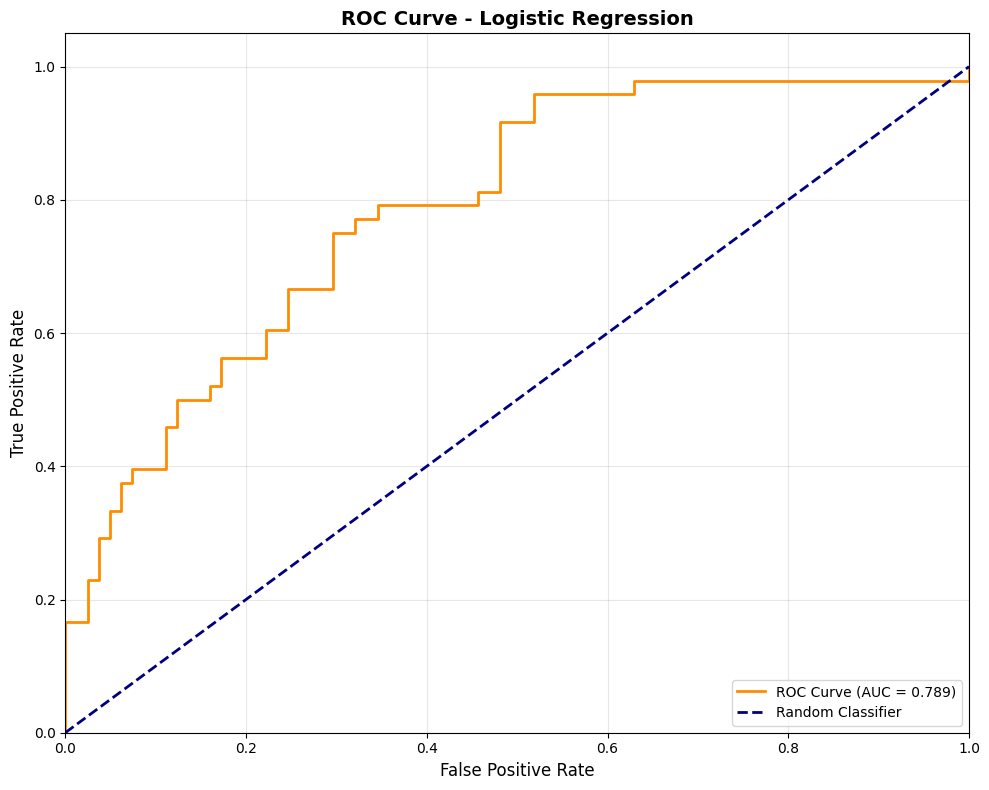

AUC Score: 0.7888



In [ ]:
# SECTION 10: ROC CURVE (Logistic Regression)
# ============================================================================

print("\n" + "="*80)
print("ROC CURVE - Logistic Regression")
print("="*80 + "\n")

lr_model = results['Logistic Regression']['model']
y_proba = lr_model.predict_proba(X_test_vec)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"AUC Score: {roc_auc:.4f}\n")

## Section 11: Export Results

**Saved Outputs:**

1. **model_summary.csv**
   - Performance metrics (accuracy, precision, recall, F1) for all models
   - Used in paper's Results section

2. **hyperpartisan_predictions.csv**
   - Raw predictions for each test article
   - Columns: Article ID, Actual Label, LR Prediction, SVM Prediction, RF Prediction, NB Prediction
   - Enables further analysis (e.g., disagreement analysis)

All files saved to `results/` directory for reproducibility and reference.


In [ ]:
print("\n" + "="*80)
print("EXPORTING RESULTS")
print("="*80 + "\n")

# Save predictions
predictions_df = pd.DataFrame({
    'Article_ID': df.loc[X_test.index, 'id'].values,
    'Actual_Label': y_test.values,
    'LR_Prediction': results['Logistic Regression']['y_pred'],
    'SVM_Prediction': results['Linear SVM']['y_pred'],
    'RF_Prediction': results['Random Forest']['y_pred'],
    'NB_Prediction': results['Naive Bayes']['y_pred']
})

predictions_df.to_csv('hyperpartisan_predictions.csv', index=False)
print("Predictions saved to 'hyperpartisan_predictions.csv'\n")

# Save model summary
summary_df.to_csv('model_summary.csv', index=False)
print("Model summary saved to 'model_summary.csv'\n")

print("="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


EXPORTING RESULTS

Predictions saved to 'hyperpartisan_predictions.csv'

Model summary saved to 'model_summary.csv'

ANALYSIS COMPLETE!


## Analysis

### Summary of Key Findings:
- **Best Model:** Linear SVM (F1: 0.699, Accuracy: 71.32%)
- **ROC-AUC:** 0.7888 (Logistic Regression)
- **Key Challenge:** Class imbalance → low recall for hyperpartisan class
- **Top Hyperpartisan Indicators:** "trump", "democrats", "liberals", "political"

### Observations:
1. Classical ML models achieve competitive performance (~71-72% accuracy)
2. TF-IDF + SVM is a strong, interpretable baseline
3. Feature analysis reveals meaningful linguistic patterns
4. Class imbalance is the primary limitation (future work: SMOTE, weighted loss)

### Next Steps (CW2 Potential):
- Implement SMOTE for handling class imbalance
- Explore deep learning (LSTM, BERT) for improved accuracy
- Incorporate metadata (publisher, author, social signals)
- Cross-domain evaluation for generalizability